In [292]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec,KeyedVectors

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense


# Reading File

In [293]:
df=pd.read_json(r'D:/Sentiment Analysis/sarcasam.json',lines=True)
df.head()

is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  
0  https://www.theonion.com/thirtysomething-scien...  
1  https://www.huffingtonpost.com/entry/donna-edw...  
2  https://www.huffingtonpost.com/entry/eat-your-...  
3  https://local.theonion.com/inclement-weather-p...  
4  https://www.theonion.com/mother-comes-pretty-c...

C:\Users\Aman\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.476396799329117 0.523603200670883


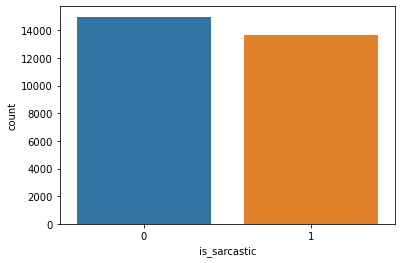

In [294]:
del df['article_link']
sns.countplot(df['is_sarcastic'])
y=df['is_sarcastic']
# These are the class weights for each class
class_1 =( len(y) - len(y[y==0]))/len(y)
class_2 =( len(y) - len(y[y==1]))/len(y)
print(class_1,class_2)

In [295]:
df['headline'][10]
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Cleaning

In [296]:
%time
stop = stopwords.words('english')
wc =WordNetLemmatizer()
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers,Remove Stopwords,then Lemmatize its.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


# Applying the cleaning function to both test and training datasets
df['headline'] = df['headline'].apply(lambda x: clean_text(x))
df.head(3)

Wall time: 0 ns


is_sarcastic                                           headline
0             1  thirtysomething scientists unveil doomsday clo...
1             0  dem rep totally nails why congress is falling ...
2             0    eat your veggies  deliciously different recipes

In [297]:
df['headline'][0]

'thirtysomething scientists unveil doomsday clock of hair loss'

# Stopwoard removal

In [298]:
def remove_stop(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
# Applying the cleaning function to both test and training datasets
df['headline'] = df['headline'].apply(lambda x: remove_stop(x))
df.head(3)

is_sarcastic                                           headline
0             1  thirtysomething scientists unveil doomsday clo...
1             0  dem rep totally nails congress falling short g...
2             0          eat veggies deliciously different recipes

In [299]:
df['headline'][0]

'thirtysomething scientists unveil doomsday clock hair loss'

# Most Frequent words

In [300]:
def counter_wrd(text):
    cnt=Counter()
    for i in text.values:
        for word in i.split():
            cnt[word]+=1
    return cnt

text=df.headline
#Frequency
counter=counter_wrd(text)
counter.most_common(10)

[('new', 1677),
 ('trump', 1389),
 ('man', 1373),
 ('report', 604),
 ('us', 601),
 ('one', 555),
 ('woman', 505),
 ('area', 494),
 ('says', 485),
 ('day', 475)]

In [301]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.headline)
corpus[:5]

['thirtysomething', 'scientists', 'unveil', 'doomsday', 'clock']

# Unigram

C:\Users\Aman\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

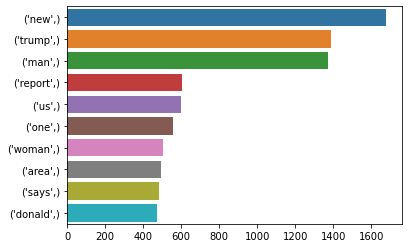

In [302]:
unigram=(pd.Series(ngrams(corpus,1)).value_counts())[:10]
sns.barplot(unigram.values,unigram.index)

# Bigrams

C:\Users\Aman\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

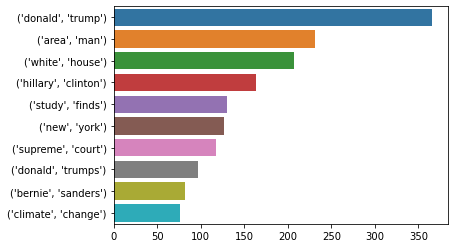

In [303]:
bigram=(pd.Series(ngrams(corpus,2)).value_counts())[:10]
sns.barplot(bigram.values,bigram.index)

# Trigrams

C:\Users\Aman\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

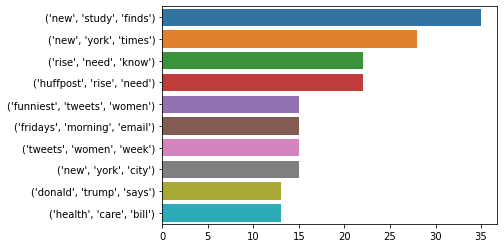

In [304]:
tri=(pd.Series(ngrams(corpus,3)).value_counts())[:10]
sns.barplot(tri.values,tri.index)

# Saracastic Words

Wall time: 0 ns


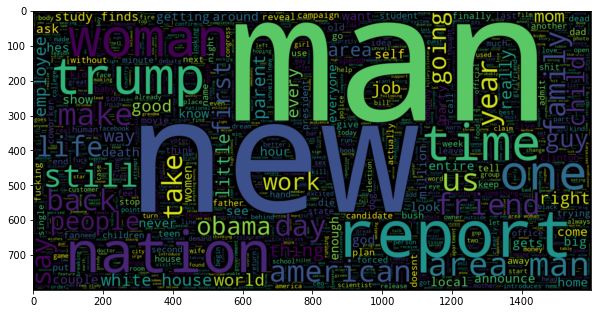

In [305]:
%time
plt.figure(figsize=(10,20))
wc=WordCloud(max_words=2000,width=1600,height=800,stopwords=STOPWORDS).generate(" ".join(df[df.is_sarcastic==1].headline))
plt.imshow(wc , interpolation = 'bilinear')

# Non Sarcastic Words

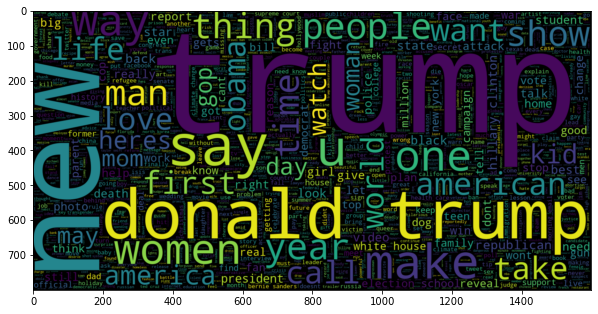

In [306]:
plt.figure(figsize=(10,20))
wc=WordCloud(max_words=2000,width=1600,height=800,stopwords=STOPWORDS).generate(" ".join(df[df.is_sarcastic==0].headline))
plt.imshow(wc,interpolation='bilinear')

In [307]:
words=[]
for i in df.headline:
    words.append(i.split())
words[:2]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender',
  'racial',
  'equality']]

# WORD2VEC

In [288]:
model=Word2Vec(sentences=words,min_count=1,vector_size=100,window=5)
#vocab size
len(model.wv)

28630

Check similar words

# Tokenization

In [313]:
words[0]

['thirtysomething',
 'scientists',
 'unveil',
 'doomsday',
 'clock',
 'hair',
 'loss']

In [312]:
tokenizer = Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_ind = tokenizer.texts_to_sequences(words)
tokenized_ind

[[15080, 238, 2943, 6082, 2172, 552, 1010],
 [7083, 1590, 609, 2944, 138, 1743, 938, 1518, 1956, 1591],
 [766, 10857, 15081, 492, 1313],
 [10858, 1457, 6083, 4312, 67, 71],
 [333, 358, 191, 871, 445, 501, 3933, 6084],
 [21, 8584],
 [164, 3934, 2299, 446, 1369],
 [1665, 15082, 10859, 2945, 978, 133, 1458, 1267, 3133, 3935],
 [2754, 198, 67, 1666, 316, 15083, 1422, 242, 2300],
 [2755, 61, 41, 7084],
 [2429, 2946, 342, 3355, 837, 6],
 [7085, 10860, 502, 401, 137, 503, 3134],
 [41, 10861, 1519, 10862, 979],
 [447, 1423, 815, 70, 26, 1520, 8585, 15084, 7086, 1011, 10863],
 [1370, 3936, 1, 6085, 1314, 10864, 8586],
 [1229, 264, 7087, 8587, 4772, 2, 1521, 7088, 1957],
 [8, 291, 1012, 15085, 3135],
 [8, 3, 2301, 10865],
 [422, 308, 3136, 231],
 [3615, 2756, 34, 13, 2302, 300, 386, 160],
 [1315, 277, 3937, 1316, 661, 2947],
 [1459, 55, 104, 4773, 1085, 1890, 3137, 7089, 15086],
 [127],
 [432, 3356, 2303, 150, 98, 93],
 [37, 26, 1958, 246, 3616, 8588, 353],
 [261, 359, 1268, 261, 531, 2757, 1508

# Padding | Embedding Representation

In [315]:
sentlen=20
emdoc=pad_sequences(tokenized_ind,padding='post',maxlen=sentlen)
print(emdoc)

[[15080   238  2943 ...     0     0     0]
 [ 7083  1590   609 ...     0     0     0]
 [  766 10857 15081 ...     0     0     0]
 ...
 [  475  3026   218 ...     0     0     0]
 [ 1688  1153  3090 ...     0     0     0]
 [  123  3059   173 ...     0     0     0]]


# Create Model

In [330]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
vocab_size = len(tokenizer.word_index) + 1 # 286300+1
embedding_vector_features=40 
model=Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=sentlen))
model.add(LSTM(500))
model.add(Dense(1,activation='sigmoid',)) # for classification problem
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 40)            1145240   
                                                                 
 lstm_3 (LSTM)               (None, 500)               1082000   
                                                                 
 dense_3 (Dense)             (None, 1)                 501       
                                                                 
Total params: 2,227,741
Trainable params: 2,227,741
Non-trainable params: 0
_________________________________________________________________
None


In [331]:
x_train, x_val, y_train, y_val = train_test_split(emdoc, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [337]:
### Finally Training
model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=3,batch_size=60)

Epoch 1/3
334/334 [==============================] - 42s 125ms/step - loss: 0.0253 - accuracy: 0.9934 - val_loss: 1.0143 - val_accuracy: 0.7799
Epoch 2/3
334/334 [==============================] - 42s 125ms/step - loss: 0.0321 - accuracy: 0.9902 - val_loss: 0.9021 - val_accuracy: 0.7784
Epoch 3/3
334/334 [==============================] - 46s 138ms/step - loss: 0.0331 - accuracy: 0.9898 - val_loss: 0.9827 - val_accuracy: 0.7749


In [336]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_val,y_val)[1]*100)

627/627 [==============================] - 21s 34ms/step - loss: 0.0139 - accuracy: 0.9975: 14s - loss: 0.0122 - accurac - ETA: 13s - loss: 0.0125 - accuracy: - ETA - ETA: 7s - loss: 0.0137 - accu - ETA: 6s - loss: 0.0134 - ac - ETA: 6s - loss: 0.0131 - ac - ETA: 4s - l - ETA:  - ETA: 2s - los
Accuracy of the model on Training Data is -  99.75041151046753
269/269 [==============================] - 9s 34ms/step - loss: 1.2343 - accuracy: 0.7793- ETA: 2s - loss: 1.2552 - accuracy - ETA: 2s - l - ETA: 1s - loss: 1.2509 - accuracy - E
Accuracy of the model on Testing Data is -  77.92918682098389


# Glove Embedding

In [346]:
embed_dict={}
with open("D:\Sentiment Analysis\glove.twitter.27B.200d.txt",'r',encoding="utf-8")as f:
    for line in f:
        val=line.split()
        word=val[0]
        vector=np.asarray(val[1:],dtype='float32')
        embed_dict[word]=vector
f.close()

In [347]:
embed_dict

{'<user>': array([ 3.1553e-01,  5.3765e-01,  1.0177e-01,  3.2553e-02,  3.7980e-03,
         1.5364e-02, -2.0344e-01,  3.3294e-01, -2.0886e-01,  1.0061e-01,
         3.0976e-01,  5.0015e-01,  3.2018e-01,  1.3537e-01,  8.7039e-03,
         1.9110e-01,  2.4668e-01, -6.0752e-02, -4.3623e-01,  1.9302e-02,
         5.9972e-01,  1.3444e-01,  1.2801e-02, -5.4052e-01,  2.7387e-01,
        -1.1820e+00, -2.7677e-01,  1.1279e-01,  4.6596e-01, -9.0685e-02,
         2.4253e-01,  1.5654e-01, -2.3618e-01,  5.7694e-01,  1.7563e-01,
        -1.9690e-02,  1.8295e-02,  3.7569e-01, -4.1984e-01,  2.2613e-01,
        -2.0438e-01, -7.6249e-02,  4.0356e-01,  6.1582e-01, -1.0064e-01,
         2.3318e-01,  2.2808e-01,  3.4576e-01, -1.4627e-01, -1.9880e-01,
         3.3232e-02, -8.4885e-01, -2.5684e-01,  2.6369e-01,  2.9562e-01,
         1.8470e-01, -2.0668e-01, -1.3297e-02,  1.2233e-01, -4.7751e-01,
        -1.7202e-01, -1.4577e-01,  4.7446e-02, -1.5824e-01,  5.4215e-02,
        -1.9426e-01, -8.1484e-02,  9.9009

In [352]:
word_index=tokenizer.word_index
EMBEDDING_DIM=200
embed_matrix=np.zeros((len(word_index)+1,EMBEDDING_DIM))
for word,i in word_index.items():
    if i<num_words:
        emb_vec=embed_dict.get(word)
        if emb_vec is not None: #words not found embedding dictionary will be 0
            embed_matrix[i]=emb_vec

In [353]:
embed_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.27553999,  0.15504999, -0.39506   , ..., -0.30039999,
         0.28612   , -0.063445  ],
       [ 0.021029  ,  0.28791001, -0.079057  , ...,  0.77636999,
        -0.45524001, -0.68147999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.25670999, -0.36362001, -0.67082   , ...,  0.48589   ,
         0.0805    , -0.99023998],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

# Train Glove Embeddings

In [371]:
from tensorflow.keras.initializers import Constant
batch_size = 128
epochs = 2
embed_size = 200
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=embed_size, embeddings_initializer=Constant(embed_matrix), input_length=sentlen, trainable=False))
#LSTM 
model.add(LSTM(100, dropout = 0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 20, 200)           5726200   
                                                                 
 lstm_9 (LSTM)               (None, 100)               120400    
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,846,701
Trainable params: 120,501
Non-trainable params: 5,726,200
_________________________________________________________________
None


In [374]:
### Finally Training
hist=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=5,batch_size=batch_size)

Epoch 1/5
157/157 [==============================] - 4s 26ms/step - loss: 0.3370 - accuracy: 0.8499 - val_loss: 0.3716 - val_accuracy: 0.8382
Epoch 2/5
157/157 [==============================] - 4s 26ms/step - loss: 0.3148 - accuracy: 0.8644 - val_loss: 0.3805 - val_accuracy: 0.8402
Epoch 3/5
157/157 [==============================] - 4s 26ms/step - loss: 0.3089 - accuracy: 0.8656 - val_loss: 0.3748 - val_accuracy: 0.8407
Epoch 4/5
157/157 [==============================] - 4s 27ms/step - loss: 0.2966 - accuracy: 0.8694 - val_loss: 0.3774 - val_accuracy: 0.8396
Epoch 5/5
157/157 [==============================] - 4s 27ms/step - loss: 0.2952 - accuracy: 0.8731 - val_loss: 0.3858 - val_accuracy: 0.8380


In [375]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_val,y_val)[1]*100)

627/627 [==============================] - 3s 4ms/step - loss: 0.1771 - accuracy: 0.9310
Accuracy of the model on Training Data is -  93.1013822555542
269/269 [==============================] - 1s 4ms/step - loss: 0.3858 - accuracy: 0.8380
Accuracy of the model on Testing Data is -  83.79920721054077


In [382]:
pred = model.predict(x_val)
preds=np.argmax(pred,axis=1)
preds[:5]

array([0, 0, 0, 0, 0], dtype=int64)